In [267]:
import nltk
import numpy as np
import pandas as pd
import itertools
from nltk.corpus import movie_reviews, stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from itertools import product
from tqdm import tqdm_notebook
import warnings

In [275]:
def ignore_warn(*args, **kwargs):
    pass

In [276]:
warnings.warn=ignore_warn

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/utk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Образец файла submission
pd.read_csv('products_sentiment_sample_submission.csv').head()

,Id,y
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


In [11]:
train_df = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None)
train_df.columns = ['texts', 'label']
test_df = pd.read_csv('products_sentiment_test.tsv', sep='\t', index_col=0)

In [112]:
test_df.head()

,text
Id,
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [12]:
train_df.head()

,texts,label
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [13]:
def c_v_scorer(vectorizer=CountVectorizer(), clf=LogisticRegression(), 
               X=train_df.texts, y=train_df.label, cv=5):
    return cross_val_score(Pipeline([('Vectorizer', vectorizer), ('Classifier', clf)]), X, y, cv=cv)

### Буду считать качество моделей по cross_val_score, и попарно сравнивать, как на прошлой неделе, чтобы найти лучший вариант

   #### CountVectorizer vs. TfIdf

In [237]:
[[j.mean(),j.std()] for j in [c_v_scorer(vect) for vect in [CountVectorizer(), TfidfVectorizer()]]]

[[0.76849568434802717, 0.007634111236534462],
 [0.7665031843949025, 0.011066947966561875]]

##### Pазница между векторайзерами несущественная, однако, буду использовать CountVectorizer()

#### CountVectorizer's min_df value

In [259]:
arr2 = [c_v_scorer(CountVectorizer(min_df=m_df)) for m_df in np.arange(0,51,10)]

In [260]:
[i.mean() for i in arr2]

[0.76849568434802717,
 0.75052440015250099,
 0.73300685004281274,
 0.72099307183169903,
 0.72299555309720687,
 0.7150017812611329]

##### Самое лучшее качество у модели с параметром по умолчанию min_df=1

#### Classifier: LogisticRegression, LinearSVC or SGDClassifie

In [277]:
[c_v_scorer(CountVectorizer(), clf=clf).mean() for clf in [LogisticRegression(), LinearSVC(), SGDClassifier()]]

[0.76849568434802717, 0.75400065312908204, 0.73299311558197233]

##### LogisticRegression() явно лучше конкурентов.

#### Stopwords

In [226]:
[c_v_scorer(CountVectorizer(stop_words=stpw)).mean() for stpw in [stopwords.words('english'), 'english', None]]

[0.75400436877730481, 0.74699938124613274, 0.76849568434802717]

##### Буду использовать модель без стоп-слов

#### Bigramms VS. single words

In [180]:
[c_v_scorer(CountVectorizer(ngram_range=ngram)).mean() for ngram in [(1,1), (1,2), (1,3)]]

[0.76849568434802717, 0.77050444377777361, 0.76651066569166049]

##### Использование биграмм сильно улучшает качество.

In [262]:
[c_v_scorer(CountVectorizer(ngram_range=ngram), LogisticRegression(class_weight='balanced')).mean() for ngram in [(1,1), (1,2), (1,3)]]

[0.76398063425396412, 0.77548945618410114, 0.77399569684810532]

##### Балансировка классов ещё немного улучшает качество модели

#### analyzer: 'char_wb' VS. 'word'

In [186]:
c_v_scorer(CountVectorizer()).mean()

0.76849568434802717

In [187]:
c_v_scorer(CountVectorizer(ngram_range=(3,5), analyzer='char_wb')).mean()

0.75949688748054667

##### Буду использовать 'word'-analyzer

In [261]:
# Вспомогательная функция, возвращающая pipeline
def pipeline(vectoriser, model):
    return Pipeline([('Vectorizer', vectoriser), ('Classifier', model)])

### Итоговая модель: CountVectorizer(ngram_range=(1,2)), LogisticRegression()

In [280]:
pipe = pipeline(CountVectorizer(ngram_range=(1,2)), LogisticRegression())
pipe.fit(train_df.texts, train_df.label)
r = pipe.predict(test_df.text)

In [251]:
pd.DataFrame.from_dict({'y' : r}).to_csv('predict_df_1.csv', index_label='id')
pd.DataFrame.from_dict({'y' : r}).y.value_counts()

1    370
0    130
Name: y, dtype: int64

Всё получилось точь-в-точь как на прошлой неделе. Как я не старалась найти комбинацию, где получалось бы качество лучше,- ничего не получилось.

По cross_val_score наилучшее качество показал векторайзер TfIdf(ngram_range=(3,5), analyzer='char_wb'), но результаты соревнований оказались провальными, поэтому я не стала включать это в ноутбук. Балансировка классов, а также L1-регуляризация тоже не показали хороших результатов.

В итоге я заняла 170-е место(

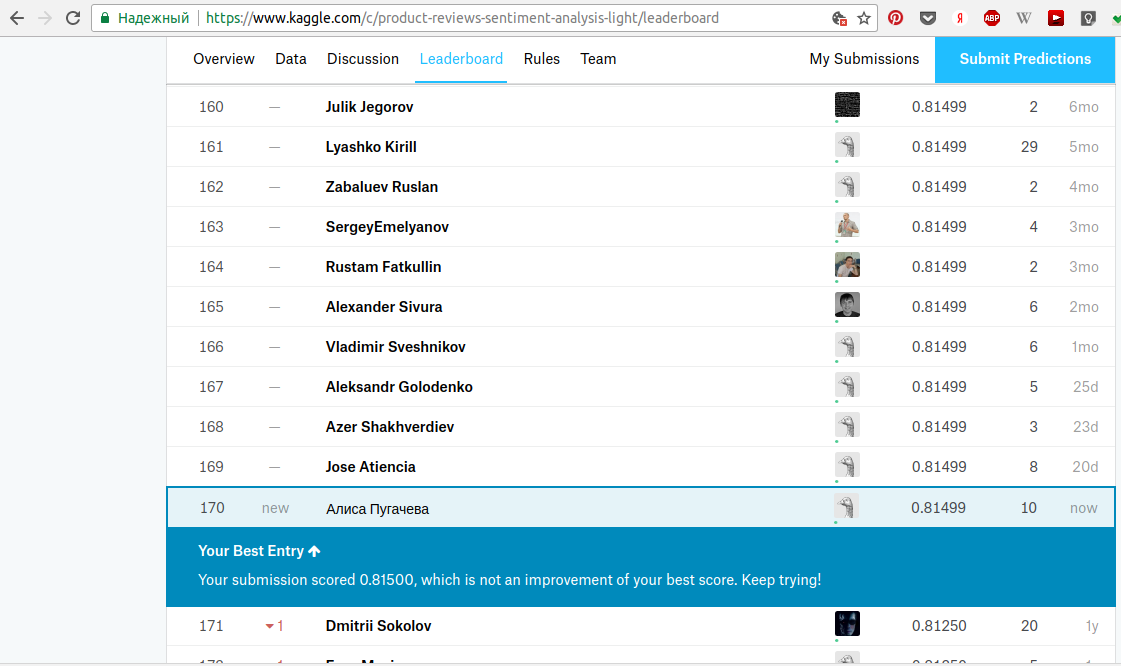